# Preprocessing and Modeling 2

In [ ]:
import pandas as pd

import sys
sys.path.append('../..')


from src.support_encoding import *
from src.support_pre import *
from src.support_plots import * 
from src.support_model import *

Comparando con la iteración anterior, eliminaremos algunas de las VP que tenían un nivel de importancia 0.

In [65]:
df = pd.read_csv("../../datos/clean_data.csv", index_col = 0)
df.drop(columns=["municipality","numPhotos", "hasPlan", "newDevelopment", "isParkingSpaceIncludedInPrice", "hasParkingSpace", "has3DTour"], inplace=True)
df.drop(index = df[df["province"] == "Segovia"].index, inplace=True)
df.reset_index(inplace=True, drop=True)
df.head()

,price,propertyType,size,exterior,rooms,bathrooms,province,showAddress,distance,hasVideo,status,has360,floor,hasLift
0,550.0,chalet,371.0,False,6,3,Toledo,False,40116,False,good,False,unknown,unknown
1,750.0,flat,60.0,True,1,1,Madrid,True,7037,False,good,False,3,True
2,750.0,flat,70.0,True,2,1,Madrid,False,16145,True,good,False,bj,False
3,400.0,penthouse,67.0,True,2,2,Madrid,False,55041,False,good,True,2,False
4,450.0,flat,89.0,False,2,1,Toledo,False,47186,False,good,False,2,True


In [66]:
df[df.select_dtypes("bool").columns] = df.select_dtypes("bool").astype("str")

In [67]:
df[["rooms", "bathrooms"]] = df[["rooms", "bathrooms"]].astype("str")

In [68]:
num_cols = df.select_dtypes("number").columns
cat_cols = df.select_dtypes("O").columns

df[num_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   price     434 non-null    float64
 1   size      434 non-null    float64
 2   distance  434 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 10.3 KB


In [69]:
df[cat_cols].head()

,propertyType,exterior,rooms,bathrooms,province,showAddress,hasVideo,status,has360,floor,hasLift
0,chalet,False,6,3,Toledo,False,False,good,False,unknown,unknown
1,flat,True,1,1,Madrid,True,False,good,False,3,True
2,flat,True,2,1,Madrid,False,True,good,False,bj,False
3,penthouse,True,2,2,Madrid,False,False,good,True,2,False
4,flat,False,2,1,Toledo,False,False,good,False,2,True


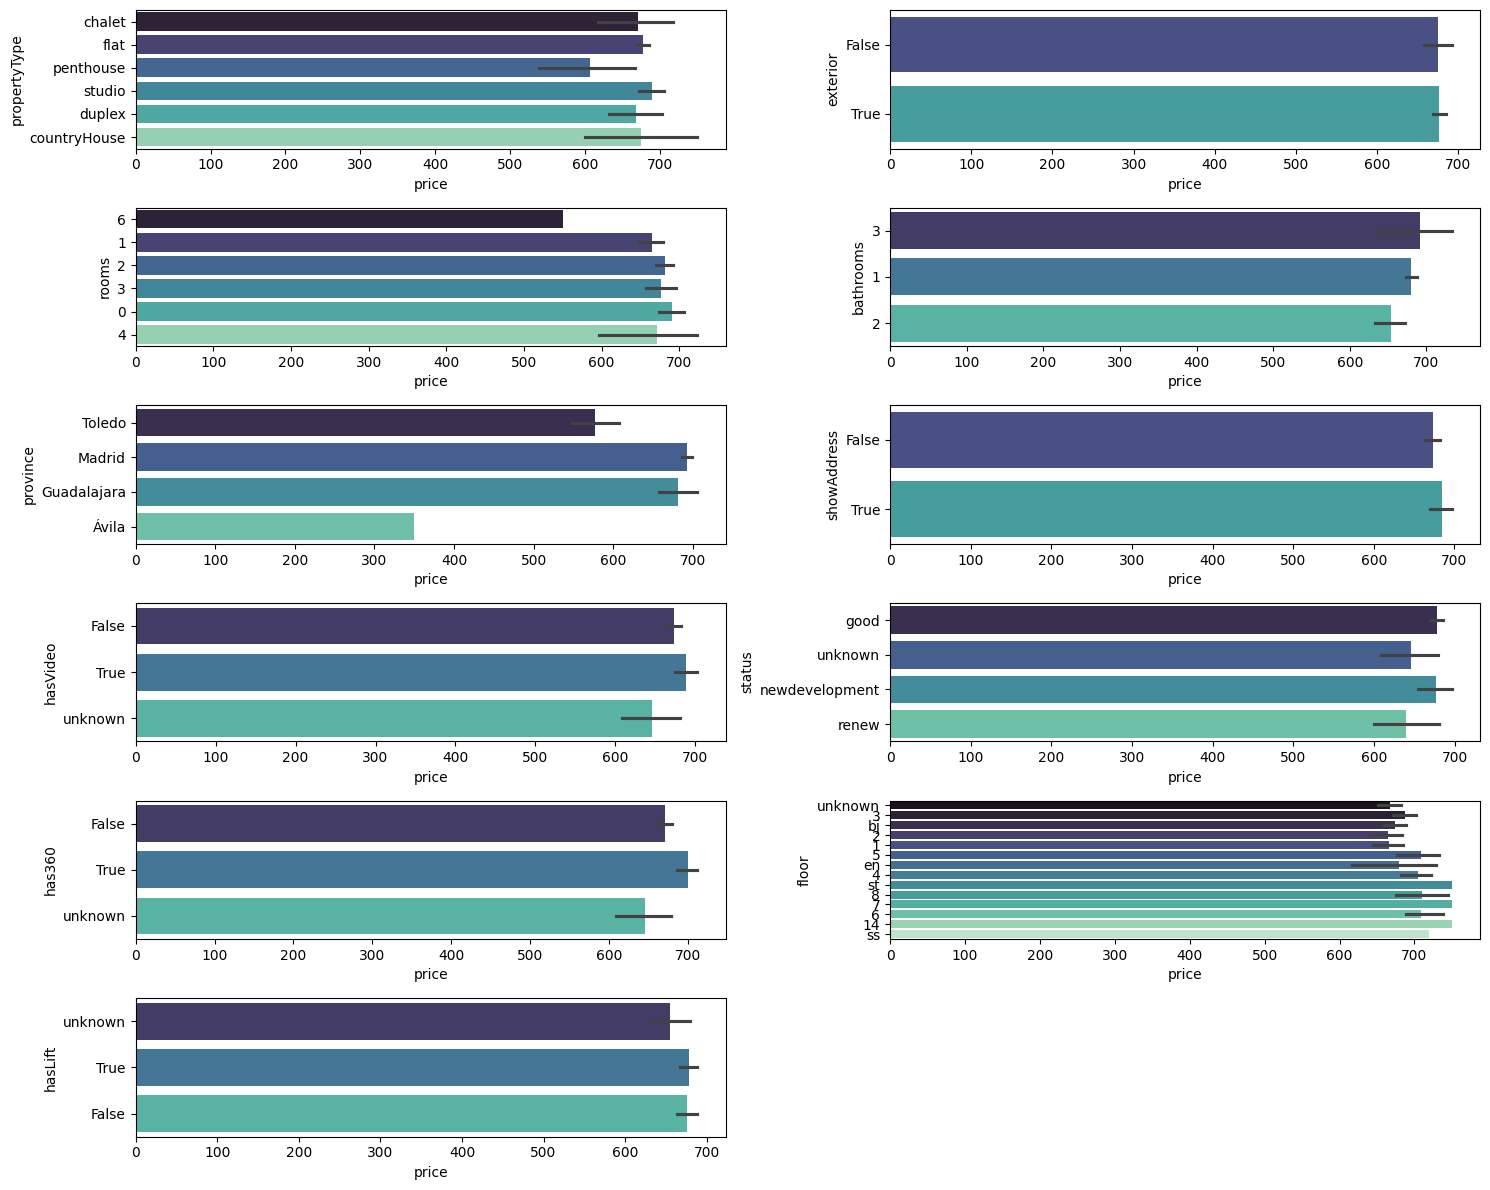

In [70]:
plot_cats(data = df, columns = cat_cols, rv = "price")

In [71]:
# asunciones = Asunciones(dataframe=df, columna_numerica="price")


# for categoria in cat_cols:   

#     print(f"Estamos analizando la variable {categoria.upper()}")
    
#     asunciones.identificar_normalidad(metodo = "shapiro") 

#     # comprobamos la homogeneidad de varianzas
#     asunciones.identificar_homogeneidad(columna_categorica = categoria)

#     # instanciamos la clase para evaluar si hay diferencias entre los distintos grupos de las variables categóricas
#     test = TestEstadisticos(df, "price", categoria)
#     test.run_all_tests()
#     print("\n###########################\n")

Aquí se ha realizado una pequeña modificación: se ha incluido rooms para las ordinales, ya que aunque no haya diferencias significativas en las medias de los precios para esta categoría, esta podría presentar un orden con respecto a otras categorías (como tamaño de la vivienda), que sí que podría afectar al precio de la vivienda.

In [72]:
cat_cols_ordinal = ["has360", "province", "bathrooms", "rooms"]
cat_cols_nominal = cat_cols.drop(cat_cols_ordinal)

#### Encoding

In [73]:
onehot_df, oh_encoder = encode_onehot(df, cat_cols_nominal)

In [ ]:
df_w_target, target_encoder = encode_target(df, cat_cols_ordinal, "price")

In [ ]:
df_encoded = pd.concat([df[num_cols], df_w_target, onehot_df], axis = 1)
df_encoded.head()

,price,size,rooms,bathrooms,province,distance,has360,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,...,floor_7,floor_8,floor_bj,floor_en,floor_ss,floor_st,floor_unknown,hasLift_False,hasLift_True,hasLift_unknown
0,550.0,371.0,659.528162,679.027033,579.743213,40116,671.176292,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,750.0,60.0,664.363794,680.495726,692.932011,7037,671.176292,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,750.0,70.0,681.088234,680.495726,692.932011,16145,671.176292,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,400.0,67.0,681.088234,653.853023,692.932011,55041,699.901503,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,450.0,89.0,681.088234,680.495726,579.743213,47186,671.176292,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Feature Scaling

Usaremos una estandarización de tipo Standard, ya que no tenemos muchos outliers, por lo que no nos interesa darles demasiado peso que pudiera introducir ruido en nuestros datos.

In [ ]:
df_scaled_cols, scaler = scale_data(data = df_encoded, columns = df_encoded.columns.drop(onehot_df.columns).drop("price"), method = "standard")
df_scaled = pd.concat([df_encoded["price"], df_scaled_cols, onehot_df], axis = 1)

In [77]:
df_scaled.head()

,price,size,rooms,bathrooms,province,distance,has360,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,...,floor_7,floor_8,floor_bj,floor_en,floor_ss,floor_st,floor_unknown,hasLift_False,hasLift_True,hasLift_unknown
0,550.0,8.434820,-1.925467,0.322369,-2.506457,1.127206,-0.457772,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,750.0,-0.216123,-1.365252,0.466782,0.419253,-0.887691,-0.457772,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,750.0,0.062042,0.572301,0.466782,0.419253,-0.332908,-0.457772,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,400.0,-0.021407,0.572301,-2.152916,0.419253,2.036313,1.976257,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,450.0,0.590557,0.572301,0.466782,-2.506457,1.557852,-0.457772,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Outliers

In [78]:
df_outliers, outlier_finder = find_outliers(data = df_scaled, columns=df_scaled.columns, method = "ifo", threshold=60)
df_outliers.head()

100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


,price,size,rooms,bathrooms,province,distance,has360,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,...,floor_7,floor_8,floor_bj,floor_en,floor_ss,floor_st,floor_unknown,hasLift_False,hasLift_True,hasLift_unknown
0,550.0,8.434820,-1.925467,0.322369,-2.506457,1.127206,-0.457772,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,400.0,-0.021407,0.572301,-2.152916,0.419253,2.036313,1.976257,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,684.0,-0.633371,1.613733,0.466782,0.419253,-0.667252,-1.184851,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
36,750.0,0.757456,0.099624,-2.152916,-2.506457,0.781715,-1.184851,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
66,750.0,-0.911536,-1.365252,0.466782,0.419253,-1.069817,-1.184851,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [79]:
df_scaled.loc[df_outliers.index, num_cols.drop('price')] = np.nan

In [80]:
df_out_imputed, outlier_imputer = impute_nulls(data=df_scaled)

[IterativeImputer] Completing matrix with shape (434, 41)
[IterativeImputer] Ending imputation round 1/10, elapsed time 5.83
[IterativeImputer] Change: 3.431545305631015, scaled tolerance: 0.75 
[IterativeImputer] Ending imputation round 2/10, elapsed time 14.11
[IterativeImputer] Change: 0.903340540372463, scaled tolerance: 0.75 
[IterativeImputer] Ending imputation round 3/10, elapsed time 22.20
[IterativeImputer] Change: 0.5996907803001079, scaled tolerance: 0.75 
[IterativeImputer] Early stopping criterion reached.


In [81]:
display(df_scaled[num_cols].describe())
df_out_imputed[num_cols].describe()

,price,size,distance
count,434.000000,409.000000,409.000000
mean,675.910138,-0.074592,-0.035057
std,81.339387,0.750374,0.978563
min,340.000000,-1.328784,-1.287698
25%,650.000000,-0.605554,-0.891590
50%,700.000000,-0.188306,-0.172345
75%,740.000000,0.312391,0.644846
max,750.000000,4.512688,2.298842


,price,size,distance
count,434.000000,434.000000,434.000000
mean,675.910138,-0.031569,0.002266
std,81.339387,0.790602,0.975397
min,340.000000,-1.328784,-1.287698
25%,650.000000,-0.549921,-0.882270
50%,700.000000,-0.160490,-0.112347
75%,740.000000,0.340208,0.740649
max,750.000000,4.512688,2.298842


In [82]:
df_out_imputed.to_csv("../../datos/Iteration2/prepped_data.csv")

In [83]:
X = df_out_imputed.drop(columns="price")
y = df_out_imputed["price"]

,R2,MAE,RMSE
Train,0.574976,40.875241,52.908488
Test,0.401337,46.386473,62.969889


No se ha realizado búsqueda en cuadrícula o no hay parámetros disponibles.
None


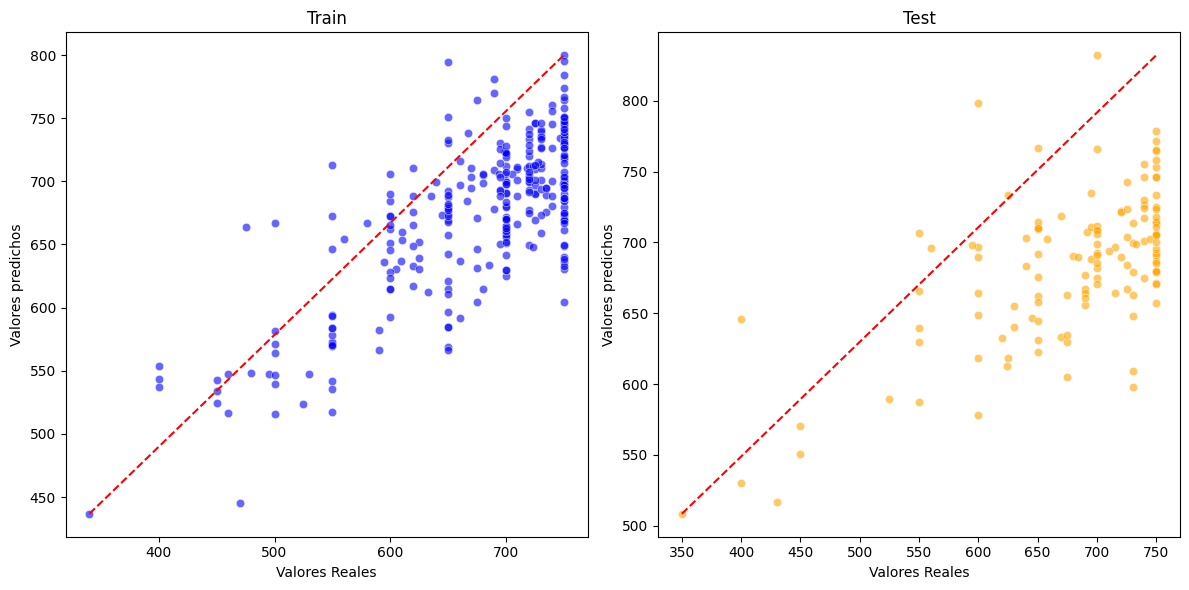

In [84]:
reg_model = RegressionModel(X, y, test_size=0.3, random_state=42)

metrics_rf = reg_model.train("linear")
reg_model.display_metrics()

print(reg_model.get_best_params())
reg_model.plot_residuals()

,R2,MAE,RMSE
Train,0.440515,46.346994,60.703359
Test,0.279268,50.239228,69.092159


{'max_depth': 2, 'max_leaf_nodes': 4, 'min_samples_leaf': 3, 'min_samples_split': 3}


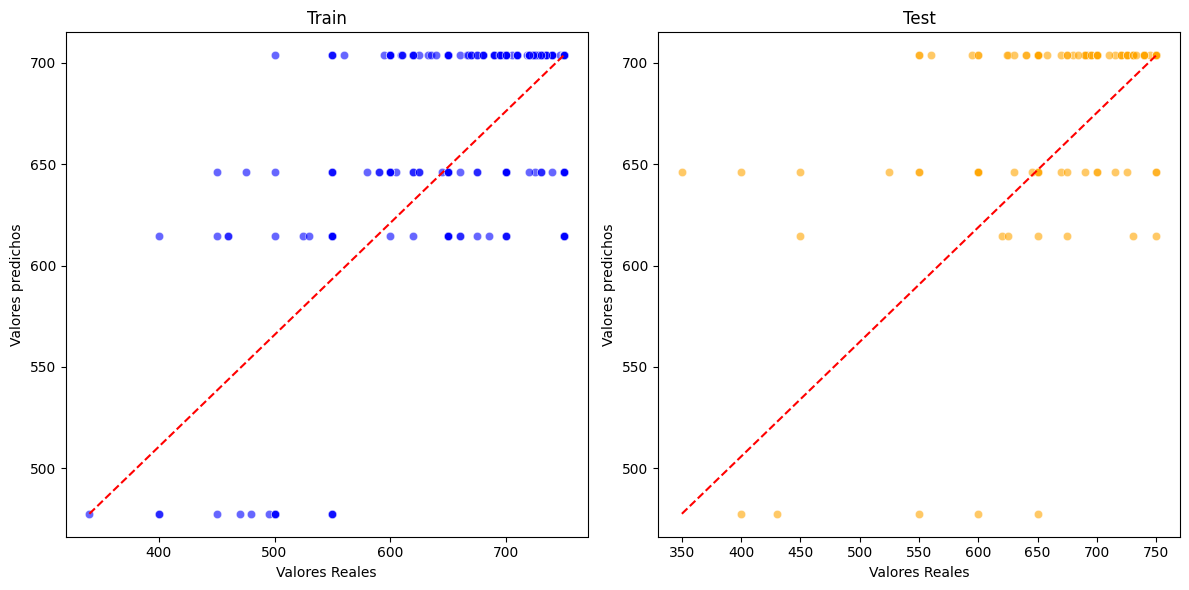

In [85]:
reg_model = RegressionModel(X, y, test_size=0.3, random_state=42)

params_rf = {'max_depth': [x for x in range(1,9)],
            'min_samples_split': [x for x in range(3,6)],
            'min_samples_leaf': [x for x in range(3,6)],
            'max_leaf_nodes': [x for x in range(3,6)]}

metrics_rf = reg_model.train("decision_tree", params=params_rf)
reg_model.display_metrics()

print(reg_model.get_best_params())
reg_model.plot_residuals()

,R2,MAE,RMSE
Train,0.551803,42.577371,54.331679
Test,0.389130,47.235373,63.608689


{'max_depth': 4, 'max_leaf_nodes': 5, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 10}


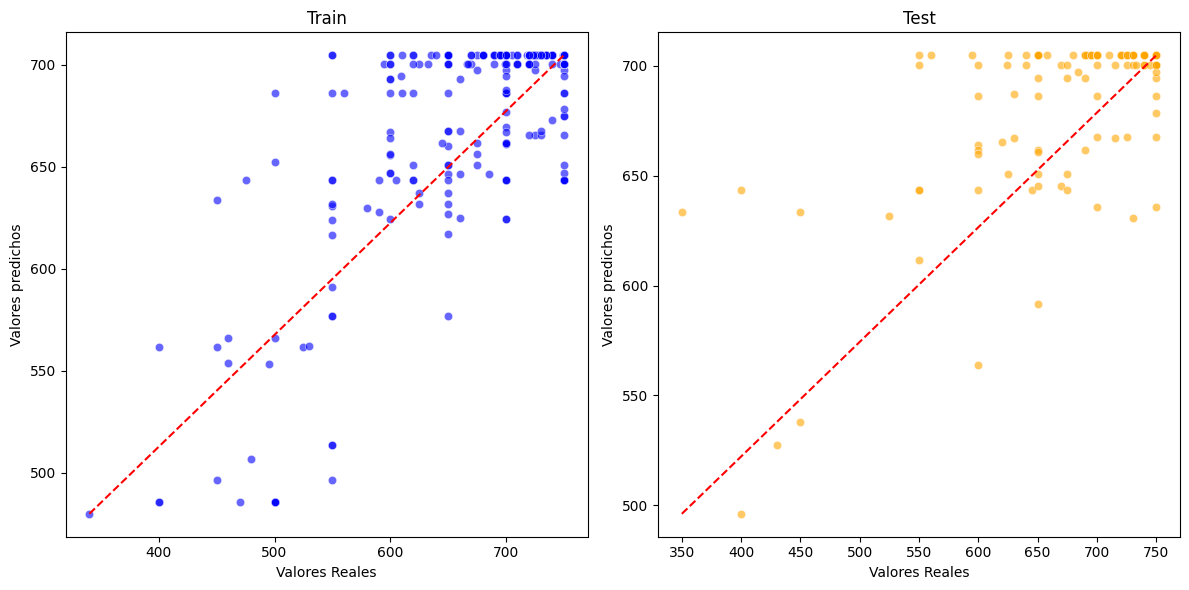

In [86]:
reg_model = RegressionModel(X, y, test_size=0.3, random_state=42)

params_rf = {'n_estimators': [x for x in range(10,90,10)],
            'max_depth': [x for x in range(1,9)],
            'min_samples_split': [x for x in range(3,6)],
            'min_samples_leaf': [x for x in range(3,6)],
            'max_leaf_nodes': [x for x in range(3,6)]}

metrics_rf = reg_model.train("random_forest", params=params_rf)
reg_model.display_metrics()

print(reg_model.get_best_params())
reg_model.plot_residuals()

,R2,MAE,RMSE
Train,0.797004,28.440070,36.564679
Test,0.539544,41.144002,55.225039


{'max_depth': 3, 'max_features': 20, 'max_leaf_nodes': 5, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 90}


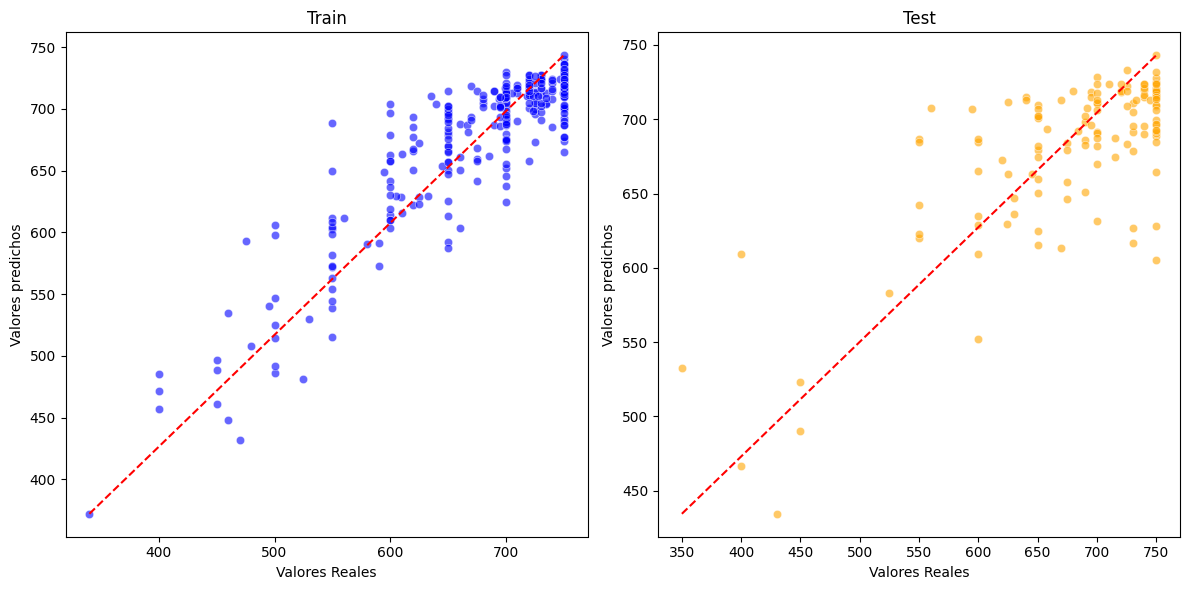

In [87]:
reg_model = RegressionModel(X, y, test_size=0.3, random_state=42)

params_gb = {'n_estimators': [x for x in range(50,100,10)],
            'max_depth': [x for x in range(1,5)],
            'min_samples_split': [x for x in range(3,7)],
            'min_samples_leaf': [x for x in range(3,7)],
            'max_leaf_nodes': [x for x in range(3,7)], 
            'max_features' : [10,20,40]}

metrics_rf = reg_model.train("gradient_boosting", params=params_gb, learning_rate=0.1)
reg_model.display_metrics()

print(reg_model.get_best_params())
reg_model.plot_residuals()

In [88]:
pd.DataFrame(reg_model.return_model().feature_importances_, index = X.columns, columns=["Importance"]).sort_values(by = "Importance", ascending=False)

,Importance
distance,0.377563
province,0.297630
size,0.155711
rooms,0.050188
exterior_True,0.020716
floor_2,0.018725
floor_unknown,0.017551
hasLift_unknown,0.014390
exterior_False,0.012045
bathrooms,0.007230


## Conclusiones

Vemos que seguimos teniendo bastante overfitting. Para la siguiente iteración intentaremos añadir de vuelta alguna de las variables predictoras.